In [ ]:
import sys

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_tester import *
import pandas as pd
import os
from shift_utils import *
from shift_constants import *
from shift_plot_utils import *
from alibi_detect.cd import ChiSquareDrift, TabularDrift
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce

sys.path.append("../..")

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import cyclops.config
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    REFERENCE_RANGE,
)
from cyclops.processors.constants import EMPTY_STRING
from cyclops.processors.admin import AdminProcessor
from cyclops.processors.vitals import VitalsProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.orm import Database

%load_ext autoreload
%load_ext nb_black

### Load data ###

In [ ]:
data = pd.read_csv("/mnt/nfs/project/delirium/data/data_2020.csv")
data = data.loc[data["hospital_id"].isin([3])]

### Plot Outcomes ###

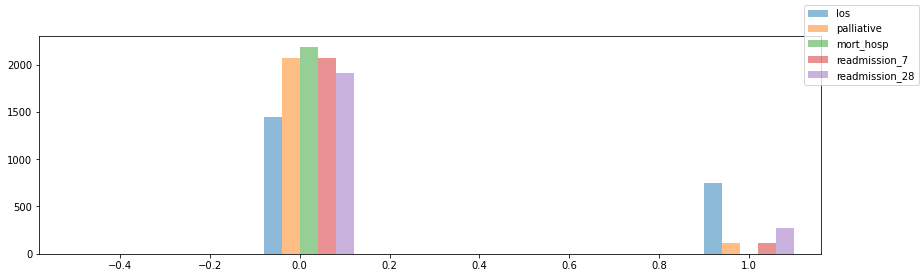

<IPython.core.display.Javascript object>

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(data["los"] - 0.08, bins=50, alpha=0.5, width=0.04, label="los")
plt.hist(data["palliative"] - 0.04, bins=50, alpha=0.5, width=0.04, label="palliative")
plt.hist(data["mort_hosp"], bins=50, alpha=0.5, width=0.04, label="mort_hosp")
plt.hist(
    data["readmission_7"] + 0.04, bins=50, alpha=0.5, width=0.04, label="readmission_7"
)
plt.hist(
    data["readmission_28"] + 0.08,
    bins=50,
    alpha=0.5,
    width=0.04,
    label="readmission_28",
)
fig.legend(loc="upper right")
plt.show()

### ER LOS ###

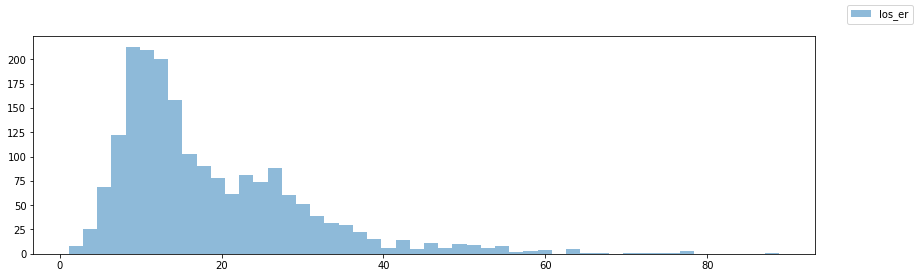

<IPython.core.display.Javascript object>

In [4]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(data["los_er"], bins=50, alpha=0.5, label="los_er")
fig.legend(loc="upper right")
plt.show()

### Triage Level ###

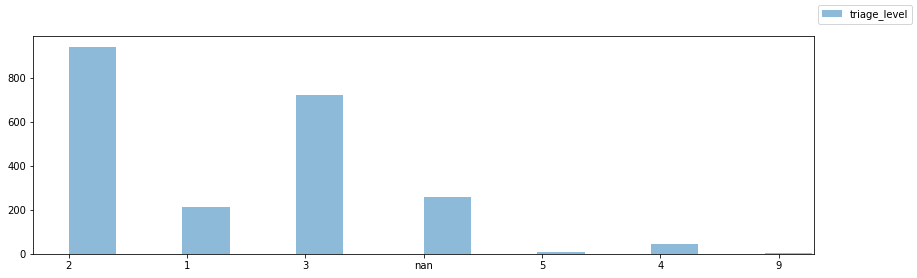

<IPython.core.display.Javascript object>

In [5]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(
    data["triage_level"].astype(str),
    bins=50,
    alpha=0.5,
    width=0.4,
    label="triage_level",
)
fig.legend(loc="upper right")
plt.show()

### ICD Codes ###

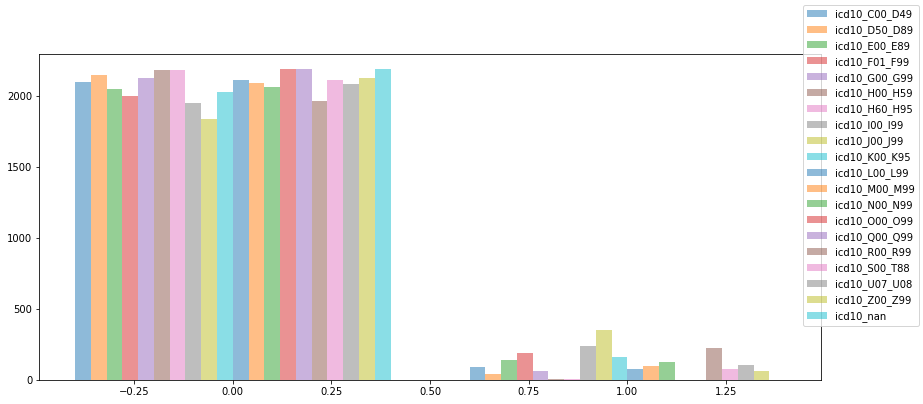

<IPython.core.display.Javascript object>

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))
ICDS = [
    "icd10_C00_D49",
    "icd10_D50_D89",
    "icd10_E00_E89",
    "icd10_F01_F99",
    "icd10_G00_G99",
    "icd10_H00_H59",
    "icd10_H60_H95",
    "icd10_I00_I99",
    "icd10_J00_J99",
    "icd10_K00_K95",
    "icd10_L00_L99",
    "icd10_M00_M99",
    "icd10_N00_N99",
    "icd10_O00_O99",
    "icd10_Q00_Q99",
    "icd10_R00_R99",
    "icd10_S00_T88",
    "icd10_U07_U08",
    "icd10_Z00_Z99",
    "icd10_nan",
]
n = len(ICDS)
w = 0.04
x = np.arange(0, len([0, 1]))
for i, icd in enumerate(ICDS):
    icd_counts = list(data[icd].value_counts())
    if len(icd_counts) == 1:
        icd_counts.append(0)
    position = x + (w * (1 - n) / 2) + i * w
    plt.bar(position, icd_counts, width=w, alpha=0.5, label=icd)
fig.legend(loc="upper right")
plt.show()

### Query Admin/Diagnosis Data ###

In [5]:
cfg = config.read_config("../../configs/default/*.yaml")
db = Database(cfg)


def query_admin_diagnosis(db, years, hospitals):
    query = (
        select(
            db.public.ip_administrative.data,
            db.public.diagnosis.data,
            db.public.er_administrative.data,
        )
        .where(
            and_(
                db.public.ip_administrative.hospital_id.in_(hospitals),
                extract("year", db.public.ip_administrative.admit_date_time).in_(years),
            )
        )
        .join(
            db.public.diagnosis.data,
            db.public.ip_administrative.genc_id == db.public.diagnosis.genc_id,
        )
        .join(
            db.public.er_administrative.data,
            db.public.er_administrative.genc_id == db.public.diagnosis.genc_id,
        )
    )

    data = db.run_query(query)

    ## gemini variables
    data["is_er_diagnosis"] = np.where(data["is_er_diagnosis"] == True, 1, 0)

    ## bret's groupings
    data["dd_discharge"] = np.where(
        data["discharge_disposition"].isin([4, 5.0, 30, 40, 90]), 1, 0
    )
    data["dd_acute"] = np.where(
        data["discharge_disposition"].isin([1]), 1, 0
    )  ## Don't use
    data["dd_mortality"] = np.where(
        data["discharge_disposition"].isin([7, 66, 72, 73]), 1, 0
    )
    data["dd_transfer"] = np.where(
        data["discharge_disposition"].isin([2, 3, 10, 20]), 1, 0
    )
    data["dd_leave_ama"] = np.where(
        data["discharge_disposition"].isin([6, 12, 61, 62, 65]), 1, 0
    )
    data["dd_suicide"] = np.where(data["discharge_disposition"].isin([67, 74]), 1, 0)

    ## lookbook groupings

    data["lb_home"] = np.where(data["discharge_disposition"].isin([4, 5, 6, 12]), 1, 0)
    data["lb_lama"] = np.where(
        data["discharge_disposition"].isin([61, 62, 65, 67]), 1, 0
    )
    data["lb_transfer"] = np.where(
        data["discharge_disposition"].isin([20, 30, 40, 90]), 1, 0
    )
    data["lb_died"] = np.where(
        data["discharge_disposition"].isin([7, 72, 73, 74]), 1, 0
    )
    data["lb_acute"] = np.where(data["discharge_disposition"].isin([1, 10]), 1, 0)
    data["lb_other"] = np.where(data["discharge_disposition"].isin([2, 3, 8, 9]), 1, 0)


    ## readmission

    data["planned_acute"] = np.where(data["readmission"] == "1", 1, 0)
    data["unplanned_readmission_7_acute"] = np.where(data["readmission"] == "2", 1, 0)
    data["unplanned_readmission_28_acute"] = np.where(data["readmission"] == "3", 1, 0)
    data["unplanned_readmission_7_surgery"] = np.where(data["readmission"] == "4", 1, 0)
    data["new_acute"] = np.where(data["readmission"] == "5", 1, 0)
    data["none"] = np.where(data["readmission"] == "9", 1, 0)

    ## los
    data["los_3"] = np.where(data["los_derived"] > 3, 1, 0)
    data["los_14"] = np.where(data["los_derived"] > 14, 1, 0)
    data["los_30"] = np.where(data["los_derived"] > 30, 1, 0)
    data["los_60"] = np.where(data["los_derived"] > 60, 1, 0)

    ## los er
    data["los_er_7"] = np.where(data["duration_er_stay_derived"] > 7, 1, 0)
    data["los_er_14"] = np.where(data["duration_er_stay_derived"] > 14, 1, 0)
    data["los_er_30"] = np.where(data["duration_er_stay_derived"] > 30, 1, 0)

    ## triage level
    data["resuscitation"] = np.where(data["triage_level"].isin(["1", "L1"]), 1, 0)
    data["emergent"] = np.where(data["triage_level"].isin(["2", "L2"]), 1, 0)
    data["urgent"] = np.where(data["triage_level"].isin(["3", "L3"]), 1, 0)
    data["less_urgent"] = np.where(data["triage_level"].isin(["4", "L4"]), 1, 0)
    data["non_urgent"] = np.where(data["triage_level"].isin(["5"]), 1, 0)
    data["unknown"] = np.where(data["triage_level"].isin(["9"]), 1, 0)

    ## city
    data["toronto"] = np.where(data["city"].isin(["TORONTO", "toronto"]), 1, 0)

    ## covid
    data["covid_confirmed"] = np.where(data["diagnosis_code"] == "U071", 1, 0)
    data["covid_suspected"] = np.where(data["diagnosis_code"] == "U072", 1, 0)

    print(f"{len(data)} rows fetched!")
    return data


def plot_outcome_overtime(hosp, outcome):

    hosp_pos = hosp.loc[hosp[outcome] == 1]
    hosp_pos_counts = (
        hosp_pos.groupby([hosp_pos["admit_date_time"].dt.to_period("m")], sort=True)
        .count()
        .eval(outcome)
    )

    hosp_counts = (
        hosp.groupby([hosp["admit_date_time"].dt.to_period("m")], sort=True)
        .count()
        .eval(outcome)
    )

    # ind = np.arange(N)
    fig, ax = plt.subplots(figsize=(14, 4))
    plt.bar(
        hosp_counts.index.values.astype(str),
        hosp_pos_counts / hosp_counts,
        alpha=0.5,
        width=0.4,
        color="g",
        label="patients with outcome/total patients",
    )
    fig.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
YEARS = ["2018", "2019", "2020"]
# HOSPITALS = SBK #THPC #MSH  #UHNTG  #UHNTW #SMH
HOSPITALS = ["SMH"]

### COVID ###

### DECREASES
# smh: acute + transfers + los_er_14 decreases, march = min home
# uhntw: acute + mortality + unplanned_readmission_7_acute + los_er_14 decreases, march = min home
# uhntg: slight er + transfer + mortality decreases
# msh: er + lama +acute + mortality + transfer decreases
# thpc: er + acute + mortality + transfers + planned_acute + unplanned_readmission_28_acute decreases
# thpm: acute +  morality + transfers decreases
# sbk: mortality +transfers + planned accute decreases

### INCREASES
# smh: lama increases, march = max mortality
# uhntw: lama increases, march = max mortality, from_nursing_home_mapped
# uhntg: march = very high planned_acute
# msh: discharge + home increases
# thpc: lama + home increases
# thpm: lama + home + unplanned_readmission_7_acute increases
# sbk: er + lama + unplanned_readmission_7_acute increases

HOSP = query_admin_diagnosis(db, YEARS, HOSPITALS)

2022-03-17 05:39:51,538 INFO cyclops.orm     - Query returned successfully!
2022-03-17 05:39:51,541 INFO cyclops.utils.profile - Finished executing function run_query in 5.000138 s


75632 rows fetched!


<IPython.core.display.Javascript object>

# IR Administrative #

### City ###

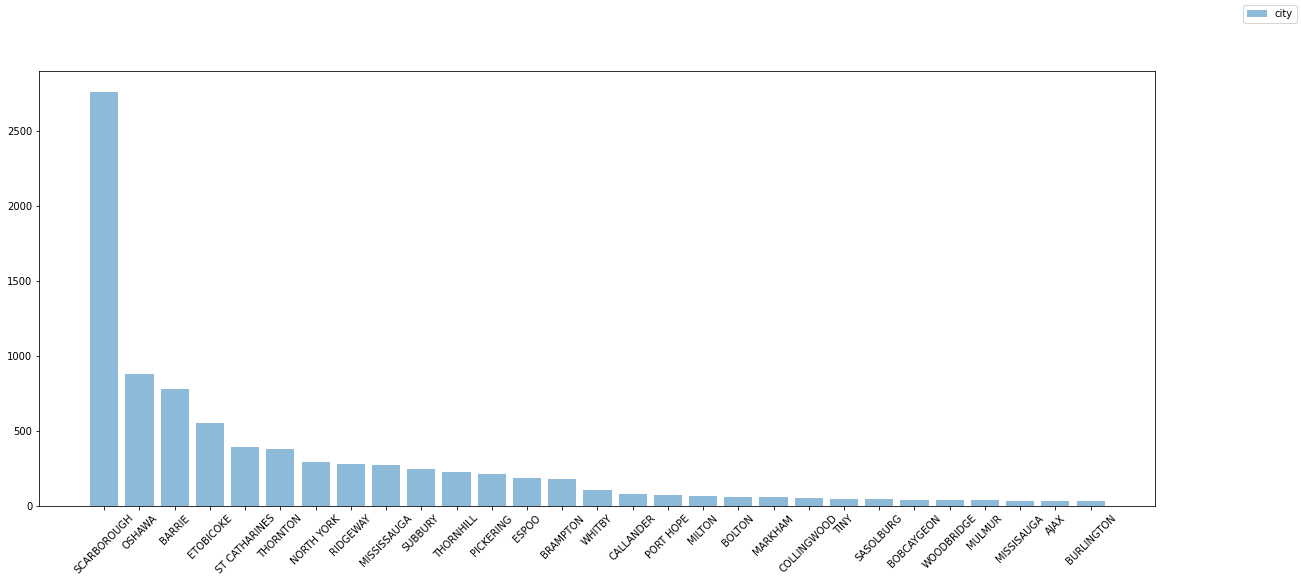

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.bar(
    list(HOSP["city"].unique()[1:30]),
    list(HOSP["city"].value_counts()[1:30]),
    alpha=0.5,
    label="city",
)
fig.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

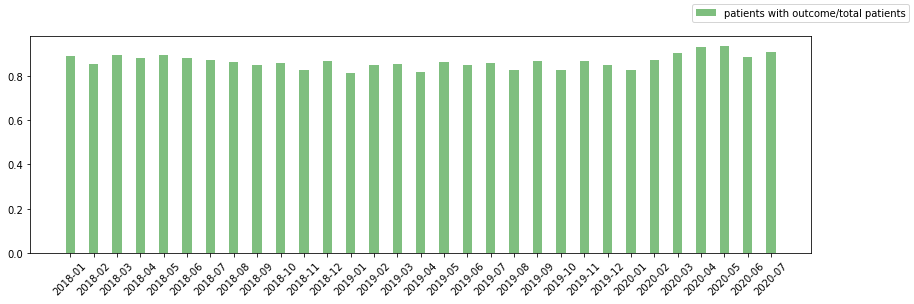

<IPython.core.display.Javascript object>

In [8]:
plot_outcome_overtime(HOSP, "toronto")

### ER Diagnosis ### 

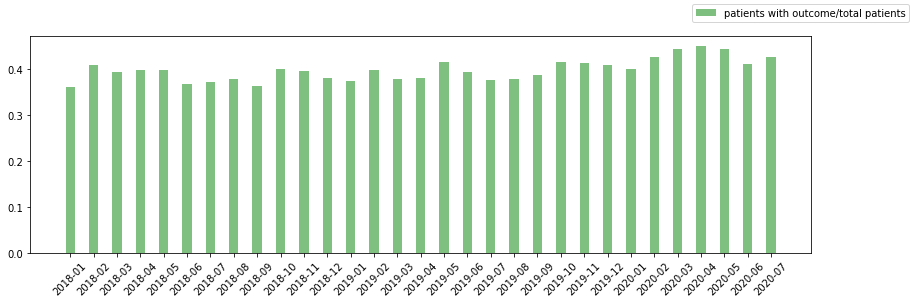

<IPython.core.display.Javascript object>

In [9]:
plot_outcome_overtime(HOSP, "is_er_diagnosis")

### From Nursing Home Mapped ### 

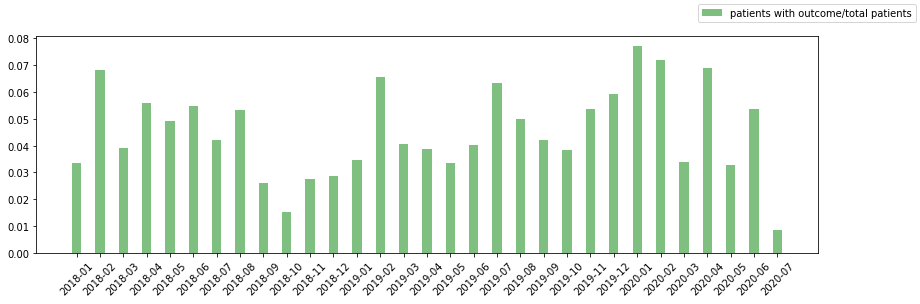

<IPython.core.display.Javascript object>

In [10]:
plot_outcome_overtime(HOSP, "from_nursing_home_mapped")

### From Acute Care Institution Mapped ### 

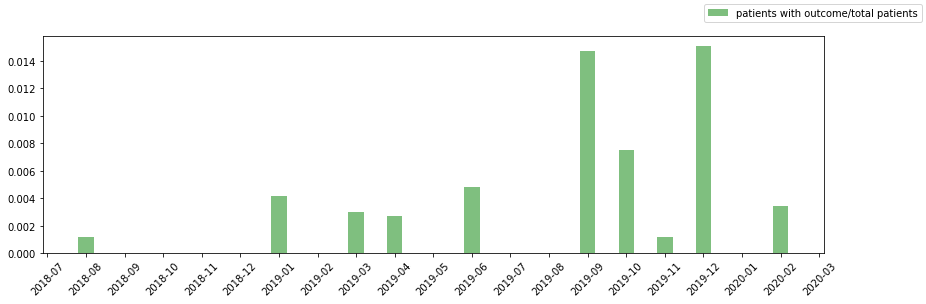

<IPython.core.display.Javascript object>

In [11]:
plot_outcome_overtime(HOSP, "from_acute_care_institution_mapped")

## Discharge Disposition ##

In [12]:
# Discharge disposition codes on GEMINI
# Bret's groupings:
# discharge: [4,5,30, 40, 90]
# acute: [1]
# mortality: [7, 66, 72, 73]
# transfer:  [2, 3, 10, 20]
# Leave AMA: [6, 12, 61, 62, 65]
# suicide: [67, 74]
# ignored: [8, 9]
# remaining: [66, 73]

DISCHARGE_DISPOSITION_MAP = {
    1: "Transferred to acute care inpatient institution",
    2: "Transferred to continuing care",
    3: "Transferred to other",
    4: "Discharged to home or a home setting with support services",
    5: "Discharged home with no support services from an external agency required",
    6: "Signed out",
    7: "Died",
    8: "Cadaveric donor admitted for organ/tissue removal",
    9: "Stillbirth",
    10: "Transfer to another hospital",
    12: "Patient who does not return from a pass",
    20: "Transfer to another ED",
    30: "Transfer to residential care",  # Transfer to long-term care home (24-hour nursing), mental health and/or addiction treatment centreor hospice/palliative care facility
    40: "Transfer to group/supportive living",  # Transfer to assisted living/supportive housing or transitional housing, including shelters; thesesettings do not have 24-hour nursing care.
    61: "Absent without leave AWOL",
    62: "AMA",
    65: "Did not return from pass/leave",
    66: "Died while on pass leave",
    67: "Suicide out of facility",
    72: "Died in facility",
    73: "MAID",
    74: "Suicide",
    90: "Transfer to correctional",
}

ip_admin_lookup_query = select(
    db.public.lookup_ip_administrative.variable,
    db.public.lookup_ip_administrative.value,
    db.public.lookup_ip_administrative.description,
).subquery()
admin_lookup_data = db.run_query(ip_admin_lookup_query)
discharge_codes = admin_lookup_data.loc[
    admin_lookup_data["variable"] == "discharge_disposition"
]
print(discharge_codes)


2022-03-17 05:39:58,947 INFO cyclops.orm     - Query returned successfully!
2022-03-17 05:39:58,950 INFO cyclops.utils.profile - Finished executing function run_query in 0.032138 s


                 variable value                  description
7   discharge_disposition     1       Acute Care Institution
8   discharge_disposition     2                        Other
9   discharge_disposition     3                        Other
10  discharge_disposition     4                         Home
11  discharge_disposition     5                         Home
12  discharge_disposition     6                         Home
13  discharge_disposition     7                         Died
14  discharge_disposition     8                        Other
15  discharge_disposition     9                        Other
16  discharge_disposition    12                         Home
17  discharge_disposition    10       Acute Care Institution
18  discharge_disposition    20         Transferred to other
19  discharge_disposition    30         Transferred to other
20  discharge_disposition    40         Transferred to other
21  discharge_disposition    90         Transferred to other
22  discharge_dispositio

<IPython.core.display.Javascript object>

### Leave AMA ### 

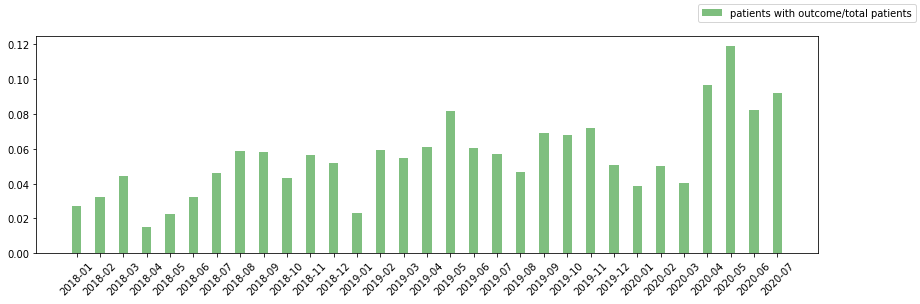

<IPython.core.display.Javascript object>

In [13]:
plot_outcome_overtime(HOSP, "dd_leave_ama")

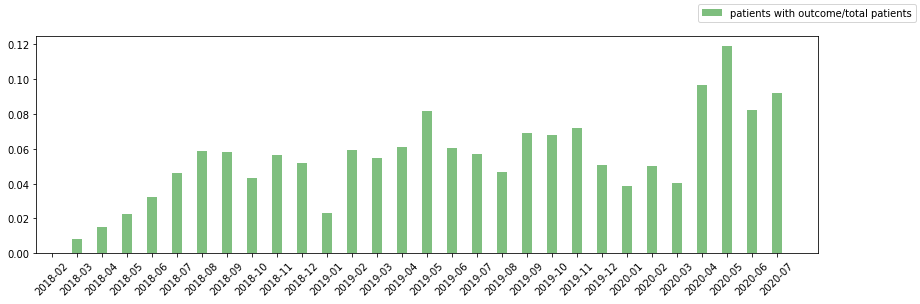

<IPython.core.display.Javascript object>

In [14]:
plot_outcome_overtime(HOSP, "lb_lama")

### Discharge ### 

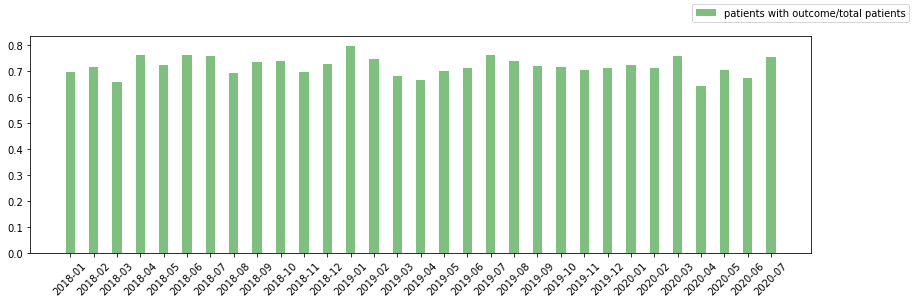

<IPython.core.display.Javascript object>

In [15]:
plot_outcome_overtime(HOSP, "dd_discharge")

### Acute  ###

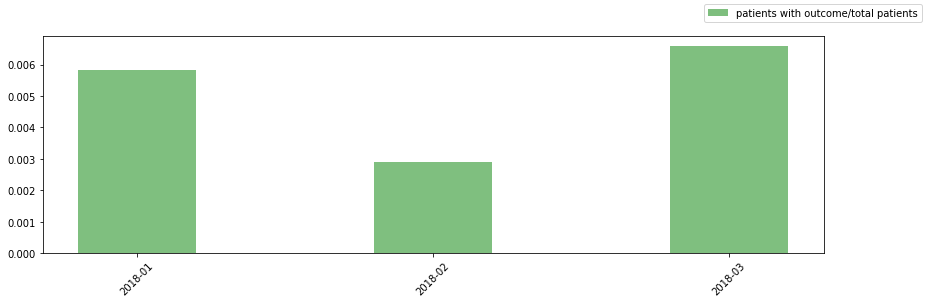

<IPython.core.display.Javascript object>

In [16]:
plot_outcome_overtime(HOSP, "dd_acute")

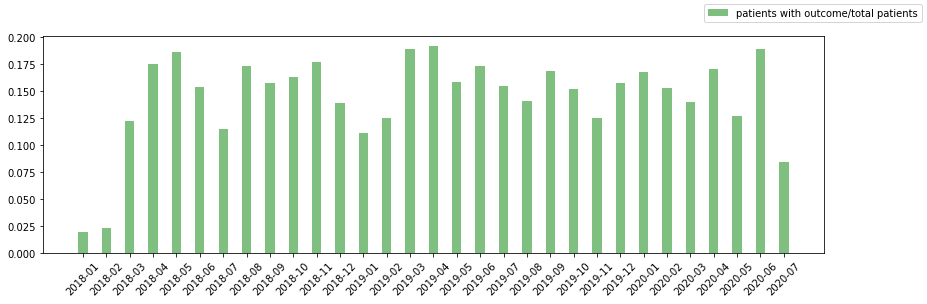

<IPython.core.display.Javascript object>

In [17]:
plot_outcome_overtime(HOSP, "lb_acute")

### Mortality ###

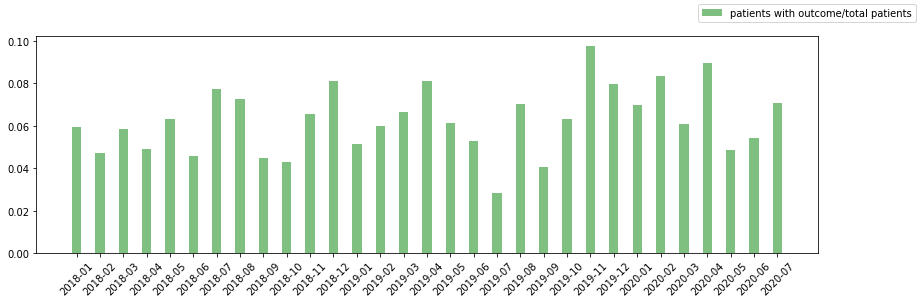

<IPython.core.display.Javascript object>

In [18]:
plot_outcome_overtime(HOSP, "dd_mortality")

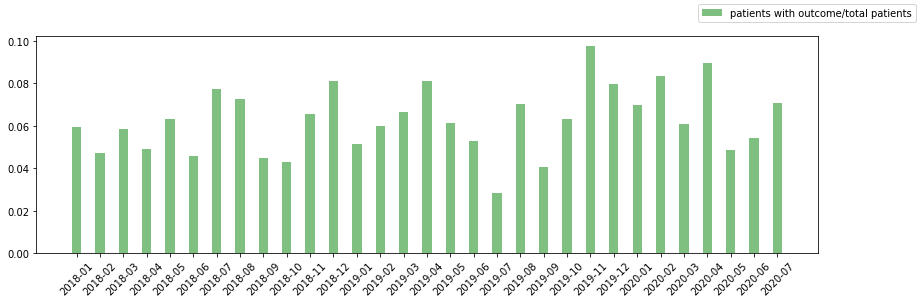

<IPython.core.display.Javascript object>

In [19]:
plot_outcome_overtime(HOSP, "lb_died")

###  Transfer ###

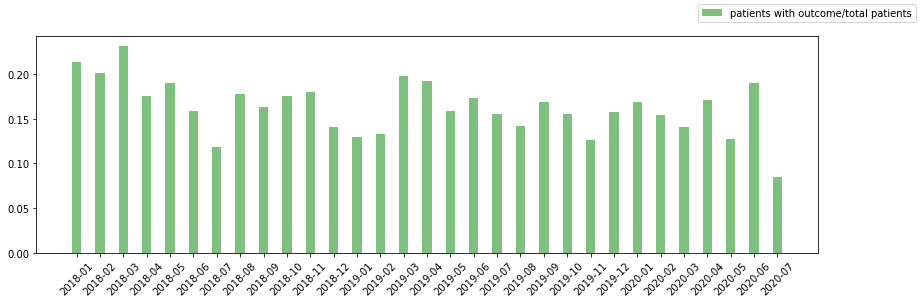

<IPython.core.display.Javascript object>

In [20]:
plot_outcome_overtime(HOSP, "dd_transfer")

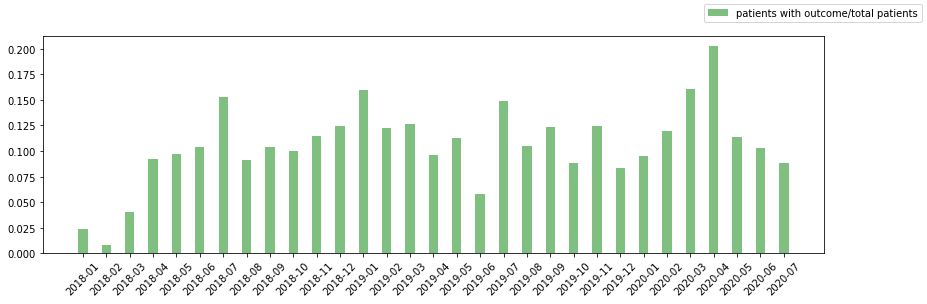

<IPython.core.display.Javascript object>

In [21]:
plot_outcome_overtime(HOSP, "lb_transfer")

### Home ###

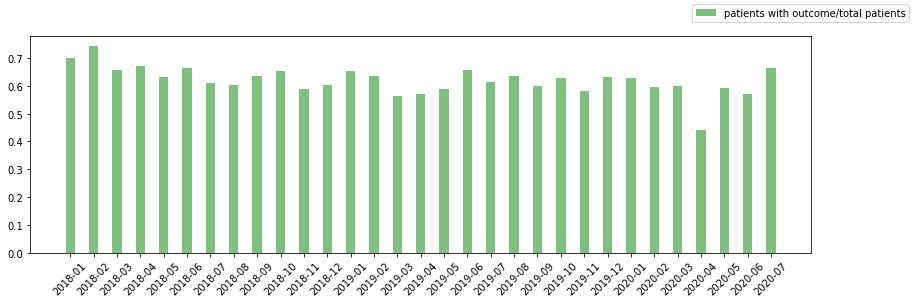

<IPython.core.display.Javascript object>

In [22]:
plot_outcome_overtime(HOSP, "lb_home")

### Other ###

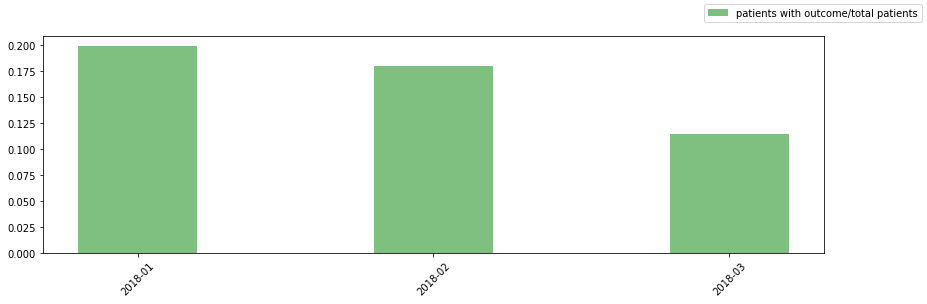

<IPython.core.display.Javascript object>

In [23]:
plot_outcome_overtime(HOSP, "lb_other")

## Readmissions ##

In [24]:
readmission_codes = admin_lookup_data.loc[
    admin_lookup_data["variable"] == "readmission"
]
print(HOSP.readmission.unique())
pd.options.display.max_colwidth = 100
print(readmission_codes)

## CASE when NULLIF(REPLACE(REPLACE(i.readmission, 'Yes', '9'), 'No', '5'), '')::numeric::integer = 2 or  NULLIF(REPLACE(REPLACE(i.readmission, 'Yes', '9'), 'No', '5'), '')::numeric::integer = 4  THEN 1 ELSE 0 END AS readmission_7,
## CASE when NULLIF(REPLACE(REPLACE(i.readmission, 'Yes', '9'), 'No', '5'), '')::numeric::integer = 2 or  NULLIF(REPLACE(REPLACE(i.readmission, 'Yes', '9'), 'No', '5'), '')::numeric::integer = 3 or  NULLIF(REPLACE(REPLACE(i.readmission, 'Yes', '9'), 'No', '5'), '')::numeric::integer = 4  THEN 1 ELSE 0 END AS readmission_28,
## CASE when g.pal =1 THEN 1 ELSE 0 END AS palliative,

['No' 'Yes' '9' '5' '3' '2' '1' '4' '']
         variable value  \
4608  readmission     1   
4609  readmission     2   
4610  readmission     3   
4611  readmission     4   
4612  readmission     5   
4613  readmission     9   

                                                                   description  
4608        Planned readmission from previous acute care (no time restriction)  
4609   Unplanned readmission within 7 days following discharge from acute care  
4610    Unplanned readmission 8 to 28 days following discharge from acute care  
4611  Unplanned readmission within 7 days following discharge from day surgery  
4612                                        New patient to the acute care unit  
4613                                                         None of the above  


<IPython.core.display.Javascript object>

### Planned Acute ###

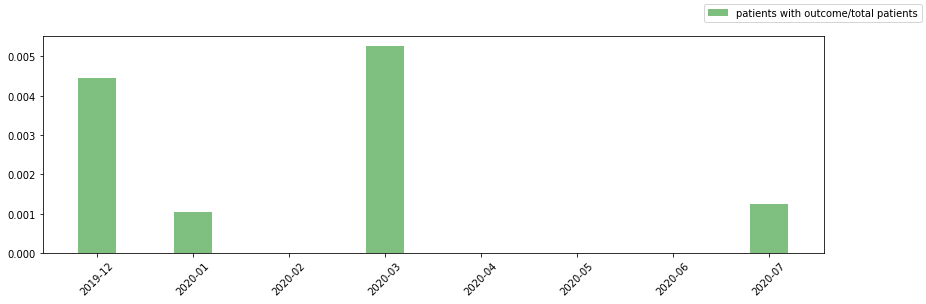

<IPython.core.display.Javascript object>

In [25]:
plot_outcome_overtime(HOSP, "planned_acute")

### Unplanned Readmission 7 Days Following Acute ###

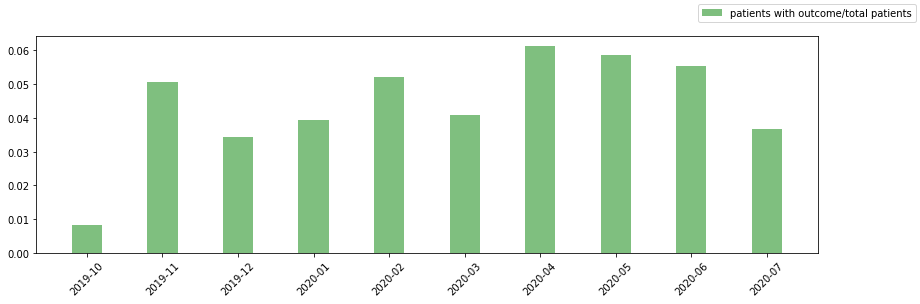

<IPython.core.display.Javascript object>

In [26]:
plot_outcome_overtime(HOSP, "unplanned_readmission_7_acute")

### Unplanned Readmission 28 Days Following Acute ###

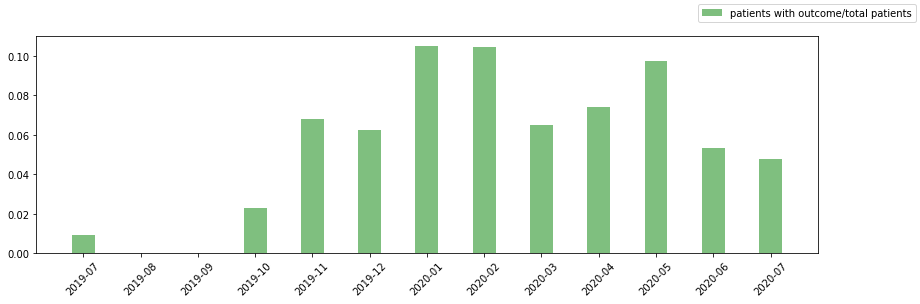

<IPython.core.display.Javascript object>

In [27]:
plot_outcome_overtime(HOSP, "unplanned_readmission_28_acute")

### Unplanned Readmission 7 Days Following Surgery ###

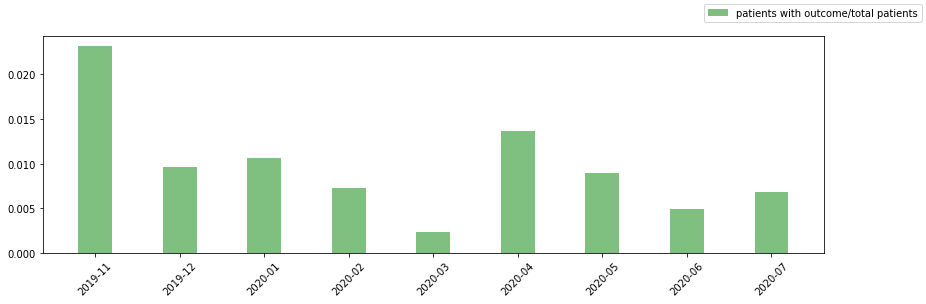

<IPython.core.display.Javascript object>

In [28]:
plot_outcome_overtime(HOSP, "unplanned_readmission_7_surgery")

### New Acute ###

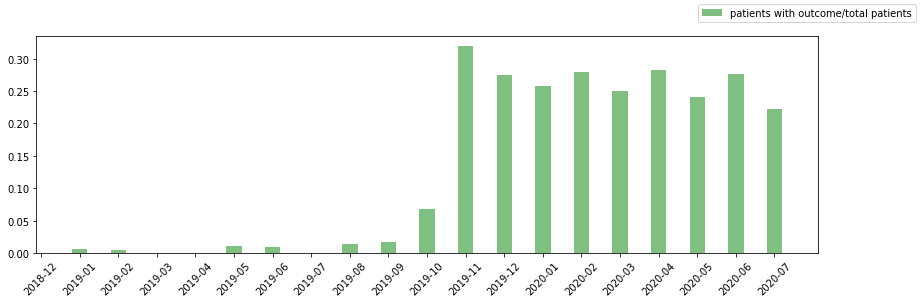

<IPython.core.display.Javascript object>

In [29]:
plot_outcome_overtime(HOSP, "new_acute")

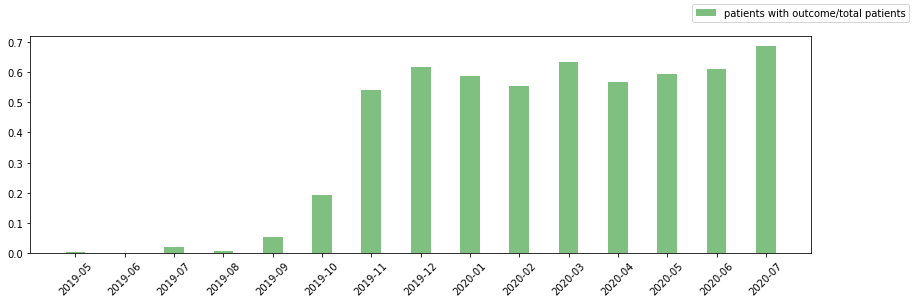

<IPython.core.display.Javascript object>

In [30]:
plot_outcome_overtime(HOSP, "none")

## Length of Stay ##

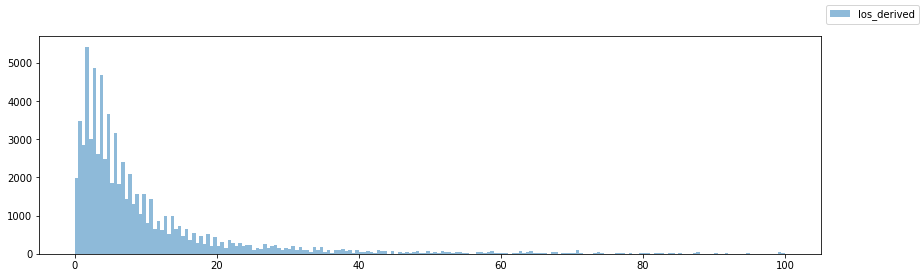

<IPython.core.display.Javascript object>

In [31]:
HOSP = HOSP.loc[HOSP["los_derived"] < 100]
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(HOSP["los_derived"], bins=200, alpha=0.5, label="los_derived")
fig.legend(loc="upper right")
plt.show()

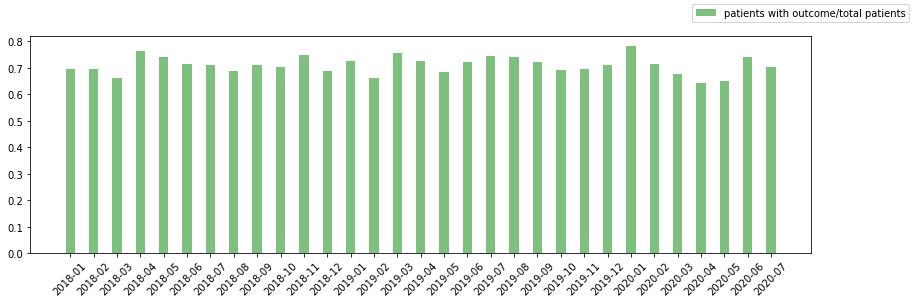

<IPython.core.display.Javascript object>

In [34]:
plot_outcome_overtime(HOSP, "los_3")

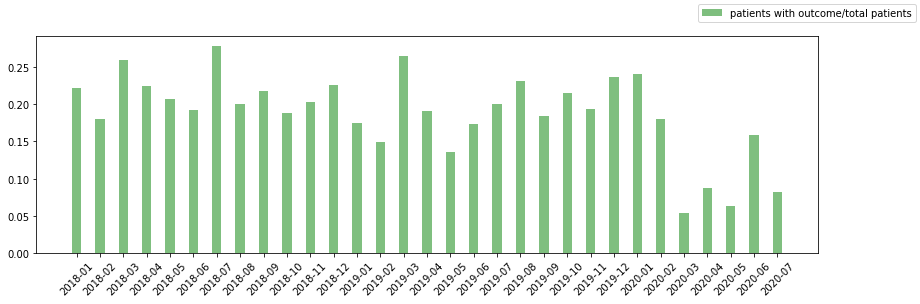

<IPython.core.display.Javascript object>

In [35]:
plot_outcome_overtime(HOSP, "los_14")

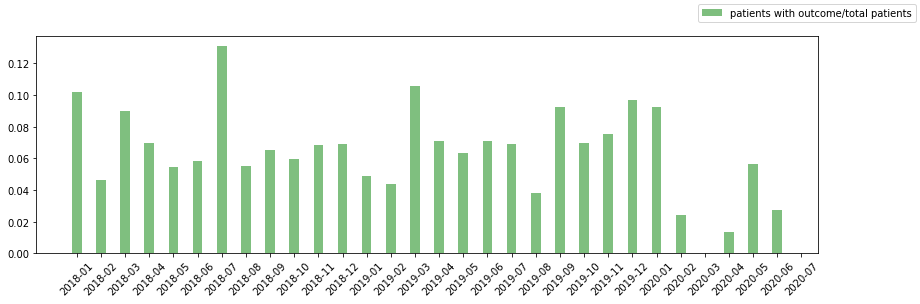

<IPython.core.display.Javascript object>

In [36]:
plot_outcome_overtime(HOSP, "los_30")

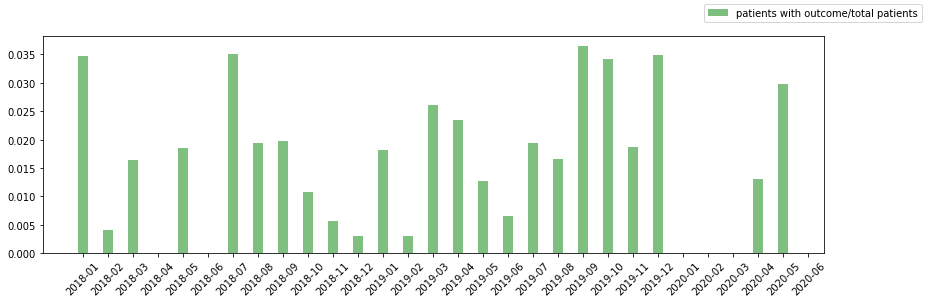

<IPython.core.display.Javascript object>

In [37]:
plot_outcome_overtime(HOSP, "los_60")

# Diagnosis # 

In [143]:
# Diagnosis lookup table on GEMINI
lookup_query = select(
    db.public.lookup_diagnosis.variable,
    db.public.lookup_diagnosis.value,
    db.public.lookup_diagnosis.description,
).subquery()
diagnosis_lookup_data = db.run_query(lookup_query)
print(diagnosis_lookup_data)
diagnosis_lookup_data_dict = diagnosis_lookup_data[["value", "description"]].to_dict()
diagnosis_type_map = {}
for key, diagnosis_type in diagnosis_lookup_data_dict["value"].items():
    diagnosis_type_map[diagnosis_type] = diagnosis_lookup_data_dict["description"][key]

2022-03-10 17:40:52,526 INFO cyclops.orm     - Query returned successfully!
INFO:cyclops.orm:Query returned successfully!
2022-03-10 17:40:52,531 INFO cyclops.utils.profile - Finished executing function run_query in 0.007757 s
INFO:cyclops.utils.profile:Finished executing function run_query in 0.007757 s


          variable value                        description
0   diagnosis_type     M         Most Responsible Diagnosis
1   diagnosis_type     1              Pre-Admit Comorbidity
2   diagnosis_type     2             Post-Admit Comorbidity
3   diagnosis_type     3                Secondary Diagnosis
4   diagnosis_type     4                   Morphology Codes
5   diagnosis_type     5                Admitting Diagnosis
6   diagnosis_type     6   Proxy Most Responsible Diagnosis
7   diagnosis_type     9      External Cause of Injury Code
8   diagnosis_type     0                            Newborn
9   diagnosis_type     W   First Service Transfer Diagnosis
10  diagnosis_type     X  Second Service Transfer Diagnosis
11  diagnosis_type     Y   Third Service Transfer Diagnosis


<IPython.core.display.Javascript object>

2022-03-10 17:40:56,387 INFO cyclops.orm     - Query returned successfully!
INFO:cyclops.orm:Query returned successfully!
2022-03-10 17:40:56,392 INFO cyclops.utils.profile - Finished executing function run_query in 3.831195 s
INFO:cyclops.utils.profile:Finished executing function run_query in 3.831195 s


130178 rows fetched!


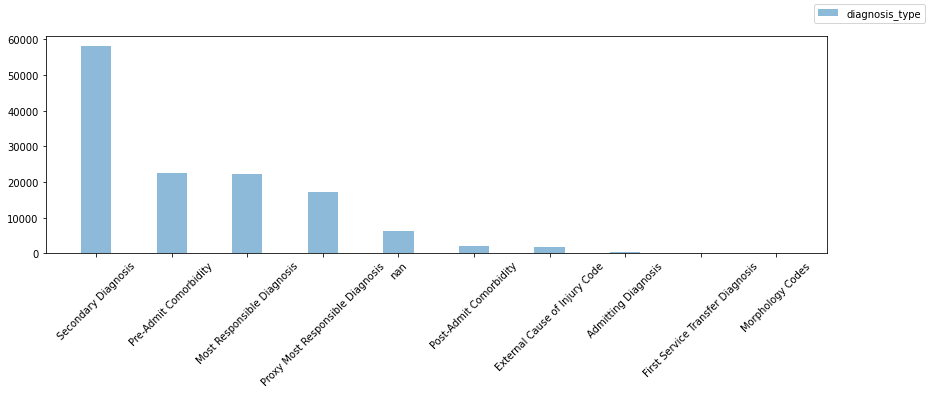

<IPython.core.display.Javascript object>

In [144]:
HOSP = query_admin_diagnosis(db, YEARS, HOSPITALS)
HOSP["diagnosis_type"] = HOSP["diagnosis_type"].map(diagnosis_type_map).astype(str)
fig, ax = plt.subplots(figsize=(14, 4))
plt.bar(
    list(HOSP["diagnosis_type"].unique()),
    HOSP["diagnosis_type"].value_counts(),
    alpha=0.5,
    width=0.4,
    label="diagnosis_type",
)
fig.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

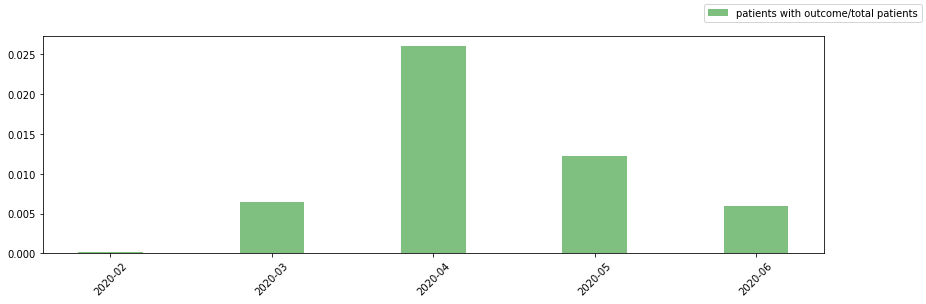

<IPython.core.display.Javascript object>

In [145]:
plot_outcome_overtime(HOSP, "covid_confirmed")

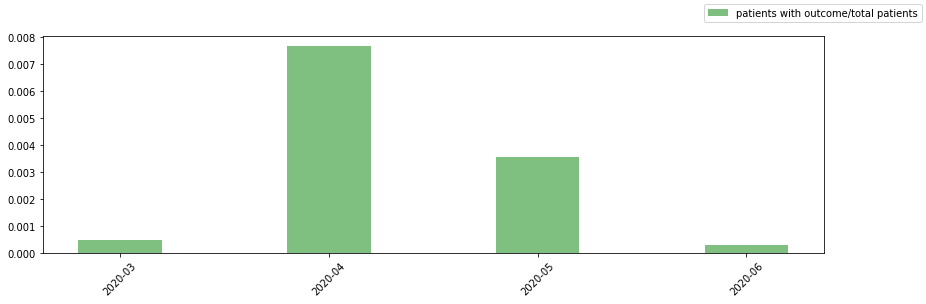

<IPython.core.display.Javascript object>

In [146]:
plot_outcome_overtime(HOSP, "covid_suspected")

# ER Admin #

In [147]:
# Diagnosis lookup table on GEMINI
lookup_query = select(
    db.public.lookup_er_administrative.variable,
    db.public.lookup_er_administrative.value,
    db.public.lookup_er_administrative.description,
).subquery()
er_admin_lookup_data = db.run_query(lookup_query)
print(er_admin_lookup_data)
er_admin_lookup_data_dict = er_admin_lookup_data[["value", "description"]].to_dict()
er_admin_type_map = {}
for key, er_admin_type in er_admin_lookup_data_dict["value"].items():
    er_admin_type_map[er_admin_type] = er_admin_lookup_data_dict["description"][key]

2022-03-10 17:41:01,446 INFO cyclops.orm     - Query returned successfully!
INFO:cyclops.orm:Query returned successfully!
2022-03-10 17:41:01,451 INFO cyclops.utils.profile - Finished executing function run_query in 0.009233 s
INFO:cyclops.utils.profile:Finished executing function run_query in 0.009233 s


               variable   value                              description
0   admit_via_ambulance       A                       Air ambulance only
1   admit_via_ambulance       G                    Ground ambulance only
2   admit_via_ambulance       C  Combination of air and ground ambulance
3   admit_via_ambulance       N                             No ambulance
4   admit_via_ambulance  GROUND                    Ground ambulance only
5          triage_level       1                            Resuscitation
6          triage_level       2                                 Emergent
7          triage_level       3                                   Urgent
8          triage_level       4                Less-urgent (semi-urgent)
9          triage_level       5                               Non-urgent
10         triage_level       9                                  Unknown
11         triage_level      L1                            Resuscitation
12         triage_level      L2                    

<IPython.core.display.Javascript object>

### Triage Level ###

2022-03-10 17:41:07,379 INFO cyclops.orm     - Query returned successfully!
INFO:cyclops.orm:Query returned successfully!
2022-03-10 17:41:07,384 INFO cyclops.utils.profile - Finished executing function run_query in 5.902681 s
INFO:cyclops.utils.profile:Finished executing function run_query in 5.902681 s


154370 rows fetched!


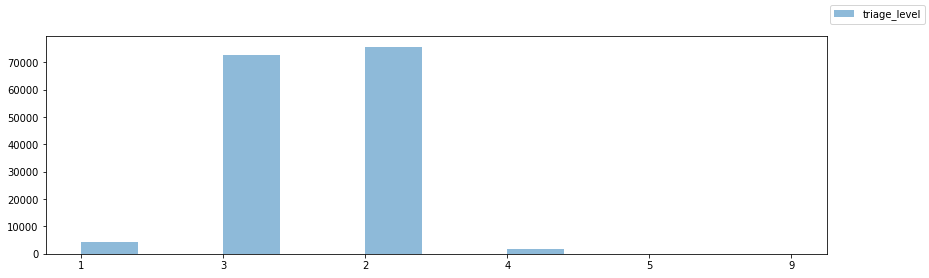

<IPython.core.display.Javascript object>

In [148]:
HOSP = query_admin_diagnosis(
    db, YEARS, ["UHNTG"]
)  # HOSPITALS = SBK #THPC #MSH  #UHNTG  #UHNTW #SMH
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(
    HOSP["triage_level"].astype(str),
    bins=50,
    alpha=0.5,
    width=0.4,
    label="triage_level",
)
fig.legend(loc="upper right")
plt.show()

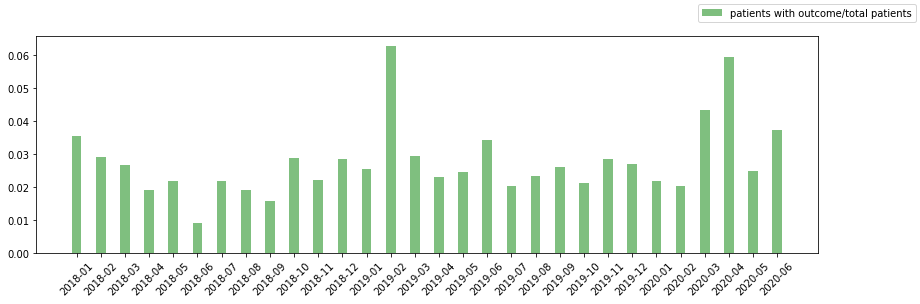

<IPython.core.display.Javascript object>

In [149]:
plot_outcome_overtime(HOSP, "resuscitation")

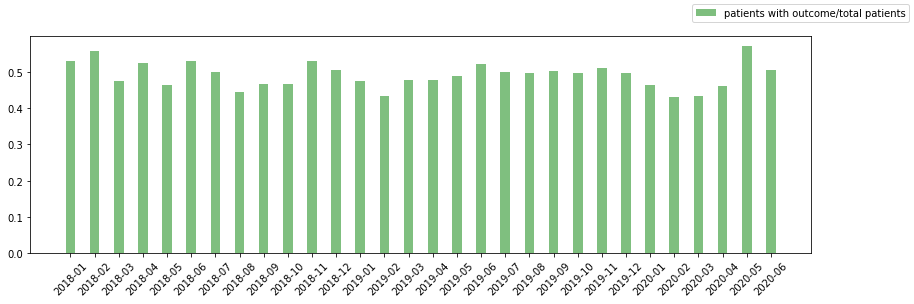

<IPython.core.display.Javascript object>

In [150]:
plot_outcome_overtime(HOSP, "emergent")

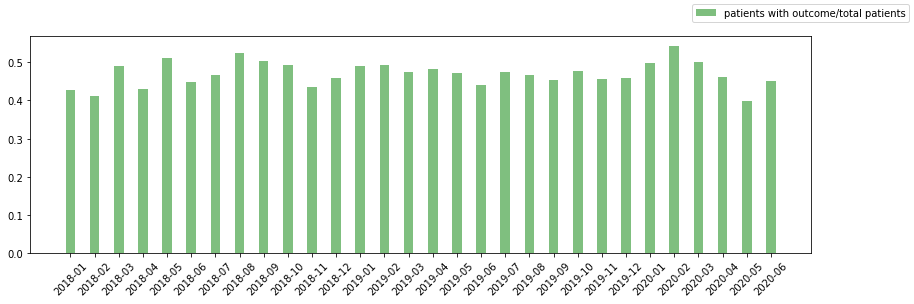

<IPython.core.display.Javascript object>

In [151]:
plot_outcome_overtime(HOSP, "urgent")

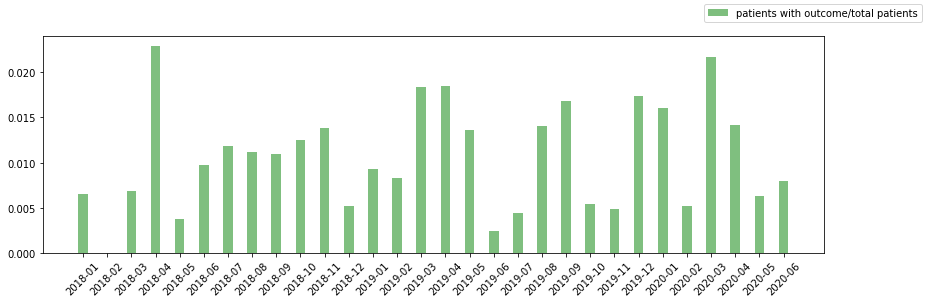

<IPython.core.display.Javascript object>

In [152]:
plot_outcome_overtime(HOSP, "less_urgent")

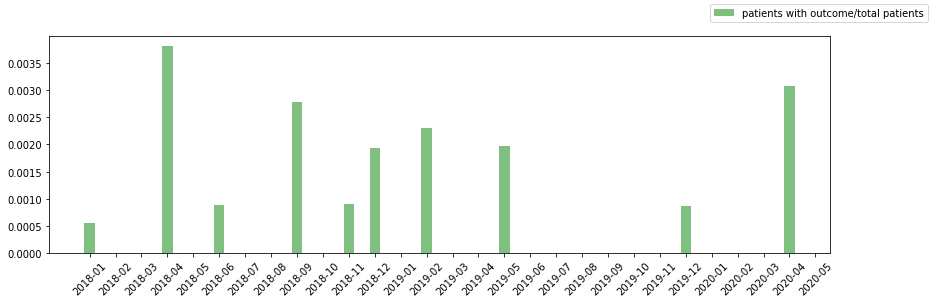

<IPython.core.display.Javascript object>

In [153]:
plot_outcome_overtime(HOSP, "non_urgent")

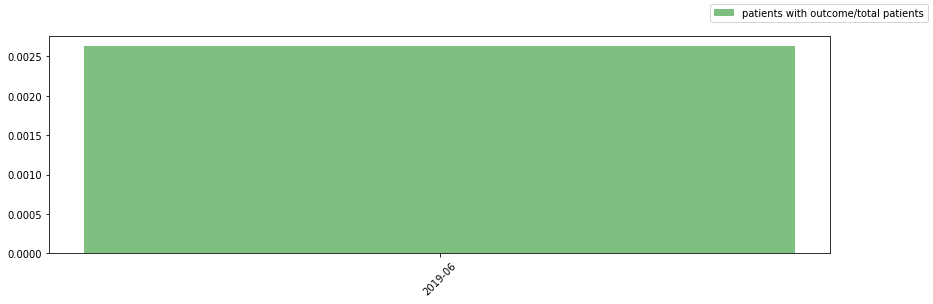

<IPython.core.display.Javascript object>

In [154]:
plot_outcome_overtime(HOSP, "unknown")

## duration_er_stay_derived ##

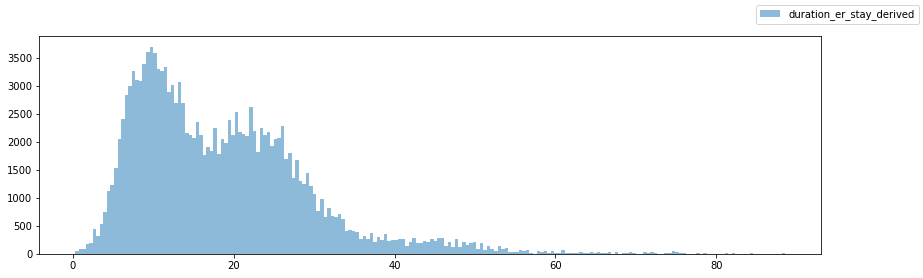

<IPython.core.display.Javascript object>

In [155]:
HOSP = HOSP.loc[HOSP["duration_er_stay_derived"] < 100]
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(
    HOSP["duration_er_stay_derived"],
    bins=200,
    alpha=0.5,
    label="duration_er_stay_derived",
)
fig.legend(loc="upper right")
plt.show()

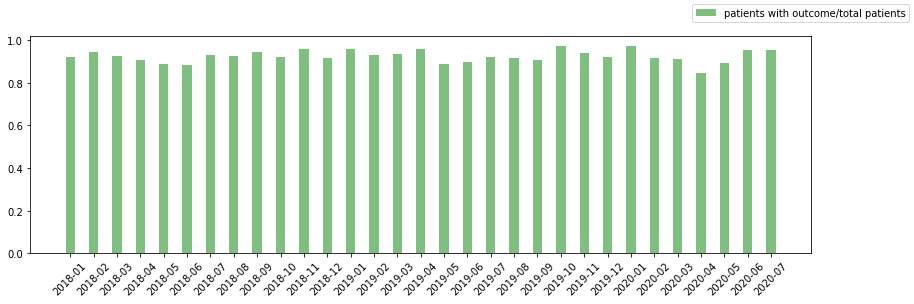

<IPython.core.display.Javascript object>

In [38]:
plot_outcome_overtime(HOSP, "los_er_7")

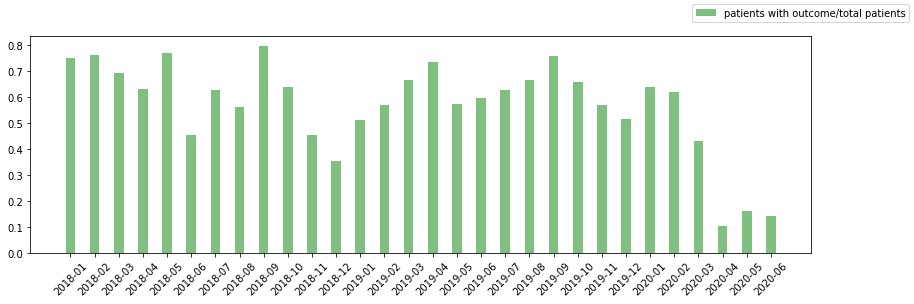

<IPython.core.display.Javascript object>

In [157]:
plot_outcome_overtime(HOSP, "los_er_14")

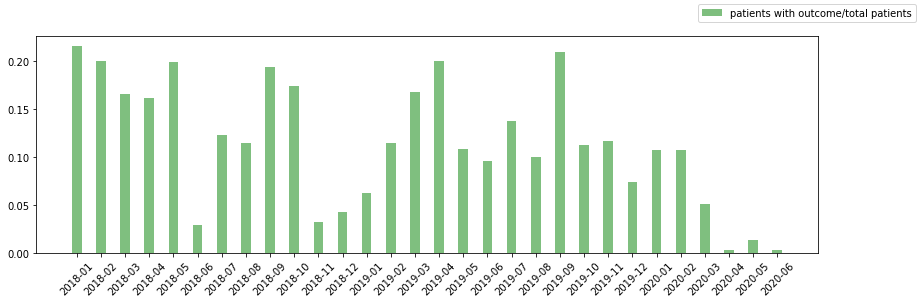

<IPython.core.display.Javascript object>

In [158]:
plot_outcome_overtime(HOSP, "los_er_30")

## CCSR Lookup ##

In [109]:
# Diagnosis lookup table on GEMINI
lookup_query = select(
    db.public.lookup_ccsr.ccsr, db.public.lookup_ccsr.ccsr_desc
).subquery()
ccsr_lookup_data = db.run_query(lookup_query)

pd.set_option("display.max_rows", None)

print(ccsr_lookup_data)

2022-03-10 17:28:22,164 INFO cyclops.orm     - Query returned successfully!
INFO:cyclops.orm:Query returned successfully!
2022-03-10 17:28:22,177 INFO cyclops.utils.profile - Finished executing function run_query in 0.130862 s
INFO:cyclops.utils.profile:Finished executing function run_query in 0.130862 s


       ccsr  \
0    BLD001   
1    BLD002   
2    BLD003   
3    BLD004   
4    BLD005   
5    BLD006   
6    BLD007   
7    BLD008   
8    BLD009   
9    BLD010   
10   CIR001   
11   CIR002   
12   CIR003   
13   CIR004   
14   CIR005   
15   CIR006   
16   CIR007   
17   CIR008   
18   CIR009   
19   CIR010   
20   CIR011   
21   CIR012   
22   CIR013   
23   CIR014   
24   CIR015   
25   CIR016   
26   CIR017   
27   CIR018   
28   CIR019   
29   CIR020   
30   CIR021   
31   CIR022   
32   CIR023   
33   CIR024   
34   CIR025   
35   CIR026   
36   CIR027   
37   CIR028   
38   CIR029   
39   CIR030   
40   CIR031   
41   CIR032   
42   CIR033   
43   CIR034   
44   CIR035   
45   CIR036   
46   CIR037   
47   CIR038   
48   CIR039   
49   DIG001   
50   DIG002   
51   DIG003   
52   DIG004   
53   DIG005   
54   DIG006   
55   DIG007   
56   DIG008   
57   DIG009   
58   DIG010   
59   DIG011   
60   DIG012   
61   DIG013   
62   DIG014   
63   DIG015   
64   DIG016   
65   DIG01

<IPython.core.display.Javascript object>